# Calculate Charging Time per Day

Read the database for BB1

If the system current is negative for an interval then assumes the system is charging.


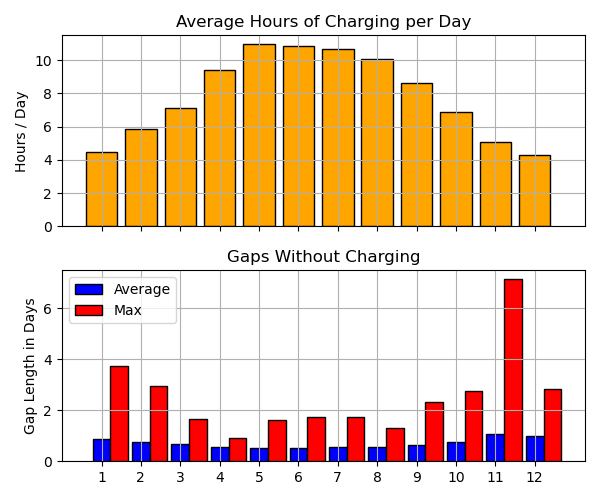

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib ipympl

Data = pd.DataFrame()
Site = 'BB/'
Dir = 'W:/'
sub_dir = 'Met/'
Time_Trace = 'clean_tv'
Traces = ['SYS_Batt_DCCurrent_Avg','SYS_PBox_Batt_Volt_Avg']

Filter_NA = [-30,5]

for year in range (2015,2023):
    filename = f'{Dir}{str(year)}/{Site}{sub_dir}{Time_Trace}'
    with open(filename, mode='rb') as file:
        Time = np.fromfile(file, 'float64')
        Time = pd.to_datetime(Time-719529,unit='D')
        for Trace in Traces:
            filename = f'{Dir}{str(year)}/{Site}{sub_dir}{Trace}'
            with open(filename, mode='rb') as file:
                trace = np.fromfile(file, 'float32')
            df = pd.DataFrame(index=Time,data={Trace:trace})
            Data = pd.concat([Data,df])

Data['Charging_Hours']=Data[Traces[0]]*0
Data['Input']=Data[Traces[0]]*0

# fig,ax=plt.subplots(figsize=(5,5))
# Data[Traces[0]].hist(edgecolor='k',bins=100)
# ax.set_title('Histogram of Current at BB1')
# ax.set_yscale('log')

# Times when current is negative are periods when system is charging
Data.loc[Data[Traces[0]]<0,'Charging_Hours']=1

# Find duration of stretches without charging
y = (Data['Charging_Hours']-1)*-1
Data['No_Power'] = y * (y.groupby((y != y.shift()).cumsum()).cumcount() + 1)

Daily = Data.resample('D').sum()/2
Daily['No_Power'] = Data.resample('D').max()['No_Power']/2

# Daily max current assumed to be representative of power demands
Daily['Draw'] = Data.resample('D').max()[Traces[0]]

#Average stats by month
Monthly = Daily.groupby(Daily.index.month).mean()
Monthly['Max_No_Power'] = Daily.groupby(Daily.index.month).max()['No_Power']

fig,axes=plt.subplots(2,figsize=(6,5),sharex=True)

ax = axes[0]
ax.bar(Monthly.index,Monthly['Charging_Hours'],edgecolor='k',color='orange')
ax.set_ylabel('Hours / Day')
ax.set_title('Average Hours of Charging per Day')
ax.grid()

ax = axes[1]
ax.bar(Monthly.index,Monthly['No_Power']/24,width=.45,edgecolor='k',color='blue',label='Average')
ax.bar(Monthly.index+.45,Monthly['Max_No_Power']/24,width=.45,edgecolor='k',color='Red',label='Max')
ax.legend()
ax.set_ylabel('Gap Length in Days')
ax.set_title('Gaps Without Charging')
ax.set_xlabel('Month')
ax.grid()

ax.set_xticks(np.arange(1,13))
plt.tight_layout()


# Power Calculator

## Instrument Specs

In [3]:
# Operating voltage
Inst_Voltage = 12

# in Watts - Can take a Range each instrument - otherwise just repeat estimate
Inst_Power_Draw = np.array([
    [8,18],#LI 7500: https://www.licor.com/env/support/LI-7500RS/topics/specifications.html - old one may be more
    [1.2,1.2] # CSAT3: https://www.campbellsci.ca/csat3 - at 20 hz
    ]) 

System_Demand = (Inst_Power_Draw.mean(axis=-1)).sum()/Inst_Voltage*24
print('Total System Demand Amps per Day: ',np.round(System_Demand,2))

Total System Demand Amps per Day:  28.4


## Power Supply

In [4]:
Batt_Voltage = 12
Batt_Amp_Hours = 40	
Batt_Weight_KG = 14.3 # Estimated from here - https://www.powerstream.com/Size_SLA.htm
Batt_per_Sequence = 1 # Can wire in sequence first to increase voltage - set to 1 = not in sequence
Batt_Sequences_in_Parallel = 6 #	Can wire in parallel to increase amperage
Discharge_Limit = .5 # Don't draw current below 50%
#Total Power Supply
N_Batt = Batt_Sequences_in_Parallel*Batt_per_Sequence
print('Number of Batteries', np.round(N_Batt,2))
Total_Batt_Weight = Batt_Weight_KG*N_Batt
print('Weight of Batteries', np.round(Total_Batt_Weight,2))
Supply_Voltage = Batt_Voltage*Batt_per_Sequence
Supply_Amp_Hours = Batt_Amp_Hours*Batt_Sequences_in_Parallel
print('Total Amp Hours', np.round(Supply_Amp_Hours,2))
Supply_Amp_Hours_Available = Supply_Amp_Hours*Discharge_Limit
print('Amp Hours Available', np.round(Supply_Amp_Hours_Available,2))
Days_to_Depletion = Supply_Amp_Hours_Available/System_Demand
print('Days of to Depletion', np.round(Days_to_Depletion,2))

Number of Batteries 6
Weight of Batteries 85.8
Total Amp Hours 240
Amp Hours Available 120.0
Days of to Depletion 4.23


## Charging Capacity

In [5]:
# Solar Panel Specs
Panel_Watts = 160 # Factory Rating
Panel_Voltage = 21
Panel_per_Sequence = 1 # Can wire in sequence first to increase voltage - set to 1 = not in sequence
Panel_Sequences_in_Parallel = 3 #	Can wire in parallel to increase amperage
Efficiency_Coef = .01 # Assume a continuous % drop / year
Panel_Age = 10

# Charging Capacity
Efficiency_Loss = Efficiency_Coef*Panel_Age
Panel_Array_Voltage = Panel_Voltage*Panel_per_Sequence
Max_Output_Watts=Panel_Watts*Panel_per_Sequence*Panel_Sequences_in_Parallel
Adjusted_Max_Output_Watts=Max_Output_Watts-(Max_Output_Watts*Efficiency_Loss)
Amps_per_Hour = np.round(Adjusted_Max_Output_Watts/Panel_Array_Voltage,1)

print('Max Output in Watts ',Adjusted_Max_Output_Watts)
print('Supply Voltage ',Panel_Array_Voltage)
print('Max Output Amps/hour ',Amps_per_Hour)

Max Output in Watts  432.0
Supply Voltage  21
Max Output Amps/hour  20.6


# Estimates

,Charging_Hours,Amps_Day,Surplus
Month,,,
1,1.1,23.0,-5.4
2,1.5,30.3,1.9
3,1.8,36.8,8.4
4,2.4,48.6,20.2
5,2.7,56.4,28.0
6,2.7,55.9,27.5
7,2.7,55.0,26.6
8,2.5,51.8,23.4
9,2.2,44.3,15.9


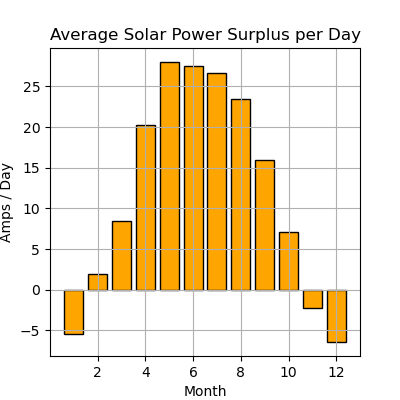

In [9]:
Scale = .25 # Assume a % of sun shine compared to BB1 to account for shading
Power_by_Day_per_Month = (Monthly[['Charging_Hours']].astype('float64')*Scale)

Power_by_Day_per_Month['Amps_Day'] = Power_by_Day_per_Month['Charging_Hours']*Amps_per_Hour
Power_by_Day_per_Month.index.name='Month'
Power_by_Day_per_Month['Surplus'] = Power_by_Day_per_Month['Amps_Day'] - System_Demand

fig,ax=plt.subplots(figsize=(4,4))
ax.bar(Power_by_Day_per_Month.index,Power_by_Day_per_Month['Surplus'],edgecolor='k',color='orange')
ax.set_ylabel('Amps / Day')
ax.set_title('Average Solar Power Surplus per Day')
ax.grid()
ax.set_xlabel('Month')

Power_by_Day_per_Month.round(1)
